In [2]:
%load_ext line_profiler
import numpy as np
import pandas as pd
from astropy.io import ascii, fits
from scipy.stats import anderson_ksamp, ks_2samp
from halotools.sim_manager import HaloTableCache, CachedHaloCatalog
from halotools.empirical_models import PrebuiltSubhaloModelFactory
import random
import time

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
#number of times to sample COSMOS dwarf catalog
n_loops = 1

print n_loops, 'loops'

1 loops


In [4]:
#Bol-Planck model
simname = 'bolshoi-planck'
halo_finder = 'rockstar'
version_name = 'bplanck_dwarfs'
ptcl_version_name='bplanck_dwarfs_downsampled2'
ptcl_version_name='bplanck_dwarfs'

redshift = 0.278625 #(1/0.78209)-1 ; a=0.78209
Lbox, particle_mass = 250, 1.5e8

#read in halocat
cache = HaloTableCache()
halocat = CachedHaloCatalog(simname = simname, halo_finder = halo_finder,
                            version_name = version_name, redshift = redshift, ptcl_version_name=ptcl_version_name) # doctest: +SKIP

print(halocat.redshift) # doctest: +SKIP
print(halocat.ptcl_version_name) # doctest: +SKIP


model = PrebuiltSubhaloModelFactory('behroozi10', redshift=redshift,
                                    scatter_abscissa=[12, 15], scatter_ordinates=[0.4, 0.2])
model.populate_mock(halocat)

0.2786
bplanck_dwarfs


In [5]:
#COSMOS data
dwarf_sample_file = '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/dwarf_sample_for_paper.fits'

dwarf_sample_data  = fits.open(dwarf_sample_file)[1].data
dwarf_masses = dwarf_sample_data['mass_med']

In [6]:
min(dwarf_masses)

7.73324

In [7]:
max(dwarf_masses)

8.99998

In [8]:
#galaxy table limited to mass range of dwarfs
mock_galaxies = model.mock.galaxy_table
mock_galaxies = mock_galaxies['galid', 'x', 'y', 'z', 'stellar_mass']
mock_galaxies = mock_galaxies[(np.log10(mock_galaxies['stellar_mass'])>=min(dwarf_masses)) & \
                              (np.log10(mock_galaxies['stellar_mass'])<9.0)]
#reduce size of table in half
mock_galaxies = mock_galaxies[random.sample(np.arange(len(mock_galaxies)),500000)]

In [24]:
def find_nearest_rows_pandas(pd_array,value, n):
    nearest_rows = np.abs(np.log10(pd_array['stellar_mass']) - value).sort_values()[:n]

    return pd_array.loc[nearest_rows.index]

def create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 1):
    
    subsample=[]
    # n_loops: number of times to sample COSMOS catalog
    
    mock_galaxies_pd = pd.DataFrame(mock_galaxies.as_array())
   
    for dwarf in dwarf_masses[:500]:   

        #reduce search space
        gal_masses=np.log10(mock_galaxies_pd['stellar_mass'])
        mock_galaxies_reduced = mock_galaxies_pd[(gal_masses<dwarf+0.001) & \
                              (gal_masses>dwarf-0.001)]


        #find index of mock galaxy with mass closes to dwarf
        matched_galaxies = find_nearest_rows_pandas(mock_galaxies_reduced,dwarf, n=n_loops)

        # append to subsample
        subsample += [matched_galaxies]

        #do not replace in array of mock galaxy masses
#         mock_galaxies_pd.drop(matched_galaxies.index)
        
        mock_galaxies_pd['stellar_mass'].loc[matched_galaxies.index] = 0
    
#         exclusion_mask = mock_galaxies_pd.index.isin(matched_galaxies.index)
#         mock_galaxies_pd = mock_galaxies_pd[~exclusion_mask]

    return pd.concat(subsample), mock_galaxies_pd

In [10]:
# %lprun -f create_dwarf_catalog_with_matched_mass_distribution2 create_dwarf_catalog_with_matched_mass_distribution2(dwarf_masses, mock_galaxies, n_loops = 50)


In [25]:
subsample, mock_galaxies_pd = create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 50)


In [26]:
print 'subsample: ' + str(len(subsample))
print 'total mock galaxies: ' + str(len(mock_galaxies))
print 'remaining mock galaxies: ' + str(len(mock_galaxies_pd[mock_galaxies_pd['stellar_mass']>0]))

#check that they are indistinguishable
#anderson_ksamp([subsample,dwarf_masses])
print ks_2samp(np.log10(subsample['stellar_mass']),dwarf_masses[:500])

subsample: 25000
total mock galaxies: 500000
remaining mock galaxies: 475000
Ks_2sampResult(statistic=0.0040000000000000036, pvalue=0.9999999999999993)


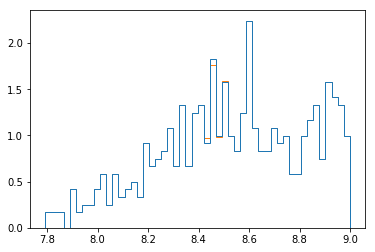

In [33]:
import matplotlib.pyplot as plt
plt.hist([dwarf_masses[:500],np.log10(subsample['stellar_mass'])], bins =50, normed=True, histtype = 'step')
plt.show()

In [34]:
#convert to script
!jupyter nbconvert --to script optimize_sampling.ipynb

[NbConvertApp] Converting notebook optimize_sampling.ipynb to script
[NbConvertApp] Writing 4194 bytes to optimize_sampling.py
